# Analysis of ATLAS-GAN results

Let's take a look at the results of the DCGAN trained to generate ATLAS RPV SUSY events.

In [1]:
# Convenient fudge for python path
import sys
sys.path.append('..')

In [2]:
# Compatibility
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# System
import os
import json

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.autograd import Variable

# Locals
from atlasgan import gan
from atlasgan.dataset import RPVImages, inverse_transform_data, generate_noise
from atlasgan.reco import compute_physics_variables

# Magics
%matplotlib notebook

In [3]:
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

## Load validation results for all HP sets

In [5]:
def load_model_config(train_dir):
    config_file = os.path.join(train_dir, 'config.json')
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def load_validation_metrics(train_dir):
    metrics_file = os.path.join(train_dir, 'validation_metrics.npz')
    return pd.DataFrame(dict(np.load(metrics_file)))

In [6]:
# Directory containing all of the training directories we want to process
results_dir = '/global/cscratch1/sd/sfarrell/atlas_gan/AtlasDCGAN_180629'

In [7]:
# Find all the training directories that have validation results avalailable
train_dirs = [os.path.join(results_dir, d) for d in os.listdir(results_dir)]
train_dirs = [d for d in train_dirs if os.path.exists(os.path.join(d, 'validation_metrics.npz'))]

# Load the results for each HP set
results = []
for i, train_dir in enumerate(train_dirs):
    config = load_model_config(train_dir)
    metrics = load_validation_metrics(train_dir)
    results.append(metrics.assign(hp=i, **config))
# Combined into single DataFrame
results = pd.concat(results, ignore_index=True)

In [8]:
# Add the combined KS metric
ks_comb = results.ks_jetPt + results.ks_nJet + results.ks_sumMass
results = results.assign(ks_comb=ks_comb)

## Find the best models

In [9]:
# Summarize the hyper-parameter sets explored
results[['hp', 'n_filters', 'noise_dim', 'lr', 'flip_rate']].drop_duplicates()

,hp,n_filters,noise_dim,lr,flip_rate
0,0,32,128,0.00020,0.021051
64,1,8,128,0.00500,0.186247
128,2,8,16,0.00100,0.047855
192,3,64,128,0.00001,0.012984
256,4,8,64,0.00100,0.067979
320,5,32,32,0.00500,0.175582
384,6,8,64,0.00001,0.077650
448,7,16,16,0.00500,0.087252
512,8,128,16,0.00010,0.135265
576,9,64,128,0.00100,0.026060


In [10]:
# Show the best model epochs across all HPs using the combined KS metric
top_k = 10
idx = results.ks_comb.sort_values().index[:top_k]
topk_results = results.loc[idx]
topk_results

,ks_nJet,ks_sumMass,ks_jetPt,ks_jetEta,ks_jetPhi,epoch,hp,flip_rate,noise_dim,image_norm,n_filters,lr,beta2,beta1,threshold,ks_comb
537,4.256377,2.841550,9.569770,25.151342,10.514511,25,8,0.135265,16,4000000.0,128,0.00010,0.999,0.5,0.000125,16.667698
554,5.357280,0.964445,10.920871,9.289027,28.375811,42,8,0.135265,16,4000000.0,128,0.00010,0.999,0.5,0.000125,17.242596
1386,4.326334,10.338959,3.120948,21.986991,61.724127,42,21,0.038879,128,4000000.0,32,0.00010,0.999,0.5,0.000125,17.786242
2015,6.152581,4.396782,7.689793,34.594309,60.834282,31,31,0.013889,64,4000000.0,32,0.00010,0.999,0.5,0.000125,18.239157
1397,4.903664,13.920761,0.755197,26.283550,53.695622,53,21,0.038879,128,4000000.0,32,0.00010,0.999,0.5,0.000125,19.579622
1628,7.798904,2.170124,11.107861,43.129680,6.218526,28,25,0.181805,128,4000000.0,128,0.00020,0.999,0.5,0.000125,21.076889
678,9.125388,9.723337,2.488834,39.824053,106.433264,38,10,0.115164,16,4000000.0,128,0.00001,0.999,0.5,0.000125,21.337559
2022,5.137090,4.949499,12.484213,44.514930,49.054545,38,31,0.013889,64,4000000.0,32,0.00010,0.999,0.5,0.000125,22.570803
1399,13.563612,4.396782,9.750795,29.163675,35.590484,55,21,0.038879,128,4000000.0,32,0.00010,0.999,0.5,0.000125,27.711188
540,5.357280,6.484448,17.111287,18.792253,15.805424,28,8,0.135265,16,4000000.0,128,0.00010,0.999,0.5,0.000125,28.953015


In [11]:
# Show the best few models from each HP
n_best = 1
hpbest_results = (results.groupby('hp', as_index=False)
                  .apply(lambda x: x.loc[x.ks_comb.sort_values().index[:n_best]]))
hpbest_results

,,ks_nJet,ks_sumMass,ks_jetPt,ks_jetEta,ks_jetPhi,epoch,hp,flip_rate,noise_dim,image_norm,n_filters,lr,beta2,beta1,threshold,ks_comb
0,28,26.853982,0.537027,7.974908,13.945686,264.102353,28,0,0.021051,128,4000000.0,32,0.00020,0.999,0.5,0.000125,35.365916
1,64,573.583192,241.784929,20.009995,70.833801,700.000000,0,1,0.186247,128,4000000.0,8,0.00500,0.999,0.5,0.000125,835.378116
2,133,5.434601,47.478797,3.241409,56.932375,197.510817,5,2,0.047855,16,4000000.0,8,0.00100,0.999,0.5,0.000125,56.154808
3,242,4.049452,17.467216,22.544490,171.612444,149.623677,50,3,0.012984,128,4000000.0,64,0.00001,0.999,0.5,0.000125,44.061158
4,294,275.630145,1.911379,142.043937,168.120635,495.757767,38,4,0.067979,64,4000000.0,8,0.00100,0.999,0.5,0.000125,419.585460
5,356,27.682421,700.000000,700.000000,258.968796,150.040051,36,5,0.175582,32,4000000.0,32,0.00500,0.999,0.5,0.000125,1427.682421
6,440,28.692748,211.608138,43.912172,455.577488,428.157023,56,6,0.077650,64,4000000.0,8,0.00001,0.999,0.5,0.000125,284.213058
7,472,197.690609,700.000000,700.000000,125.987698,84.054888,24,7,0.087252,16,4000000.0,16,0.00500,0.999,0.5,0.000125,1597.690609
8,537,4.256377,2.841550,9.569770,25.151342,10.514511,25,8,0.135265,16,4000000.0,128,0.00010,0.999,0.5,0.000125,16.667698
9,580,17.870022,197.690609,10.460465,24.692067,38.047277,4,9,0.026060,128,4000000.0,64,0.00100,0.999,0.5,0.000125,226.021096


### Scatter plots of metrics vs. HP values

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


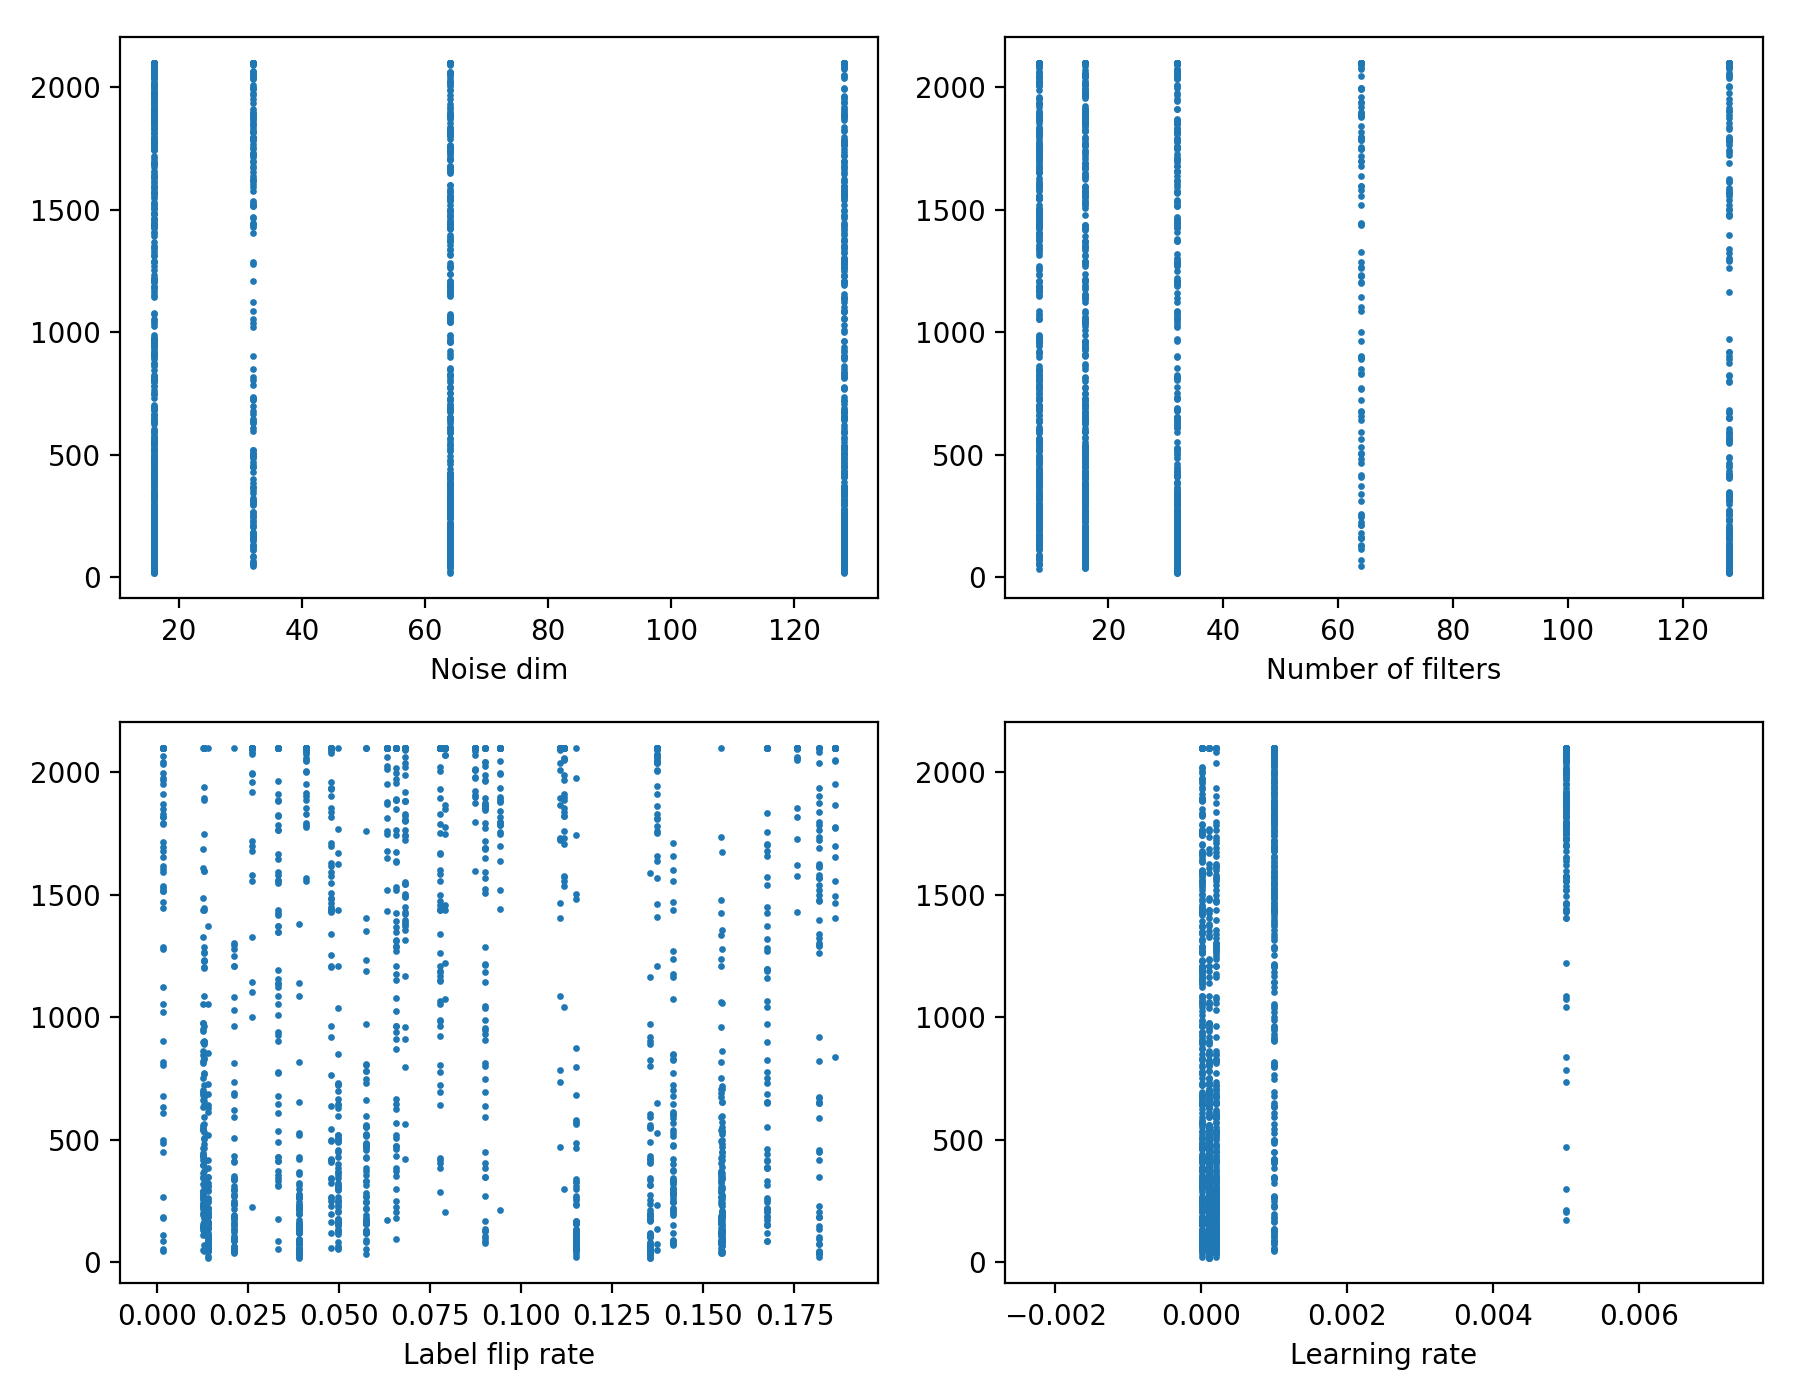

In [13]:
# Metrics vs. noise-dim for all models
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs[0,0].scatter(results.noise_dim, results.ks_comb, s=2)
axs[0,0].set_xlabel('Noise dim')
axs[0,1].scatter(results.n_filters, results.ks_comb, s=2)
axs[0,1].set_xlabel('Number of filters')
axs[1,0].scatter(results.flip_rate, results.ks_comb, s=2)
axs[1,0].set_xlabel('Label flip rate')
axs[1,1].scatter(results.lr, results.ks_comb, s=2)
axs[1,1].set_xlabel('Learning rate')
plt.tight_layout()

<IPython.core.display.Javascript object>


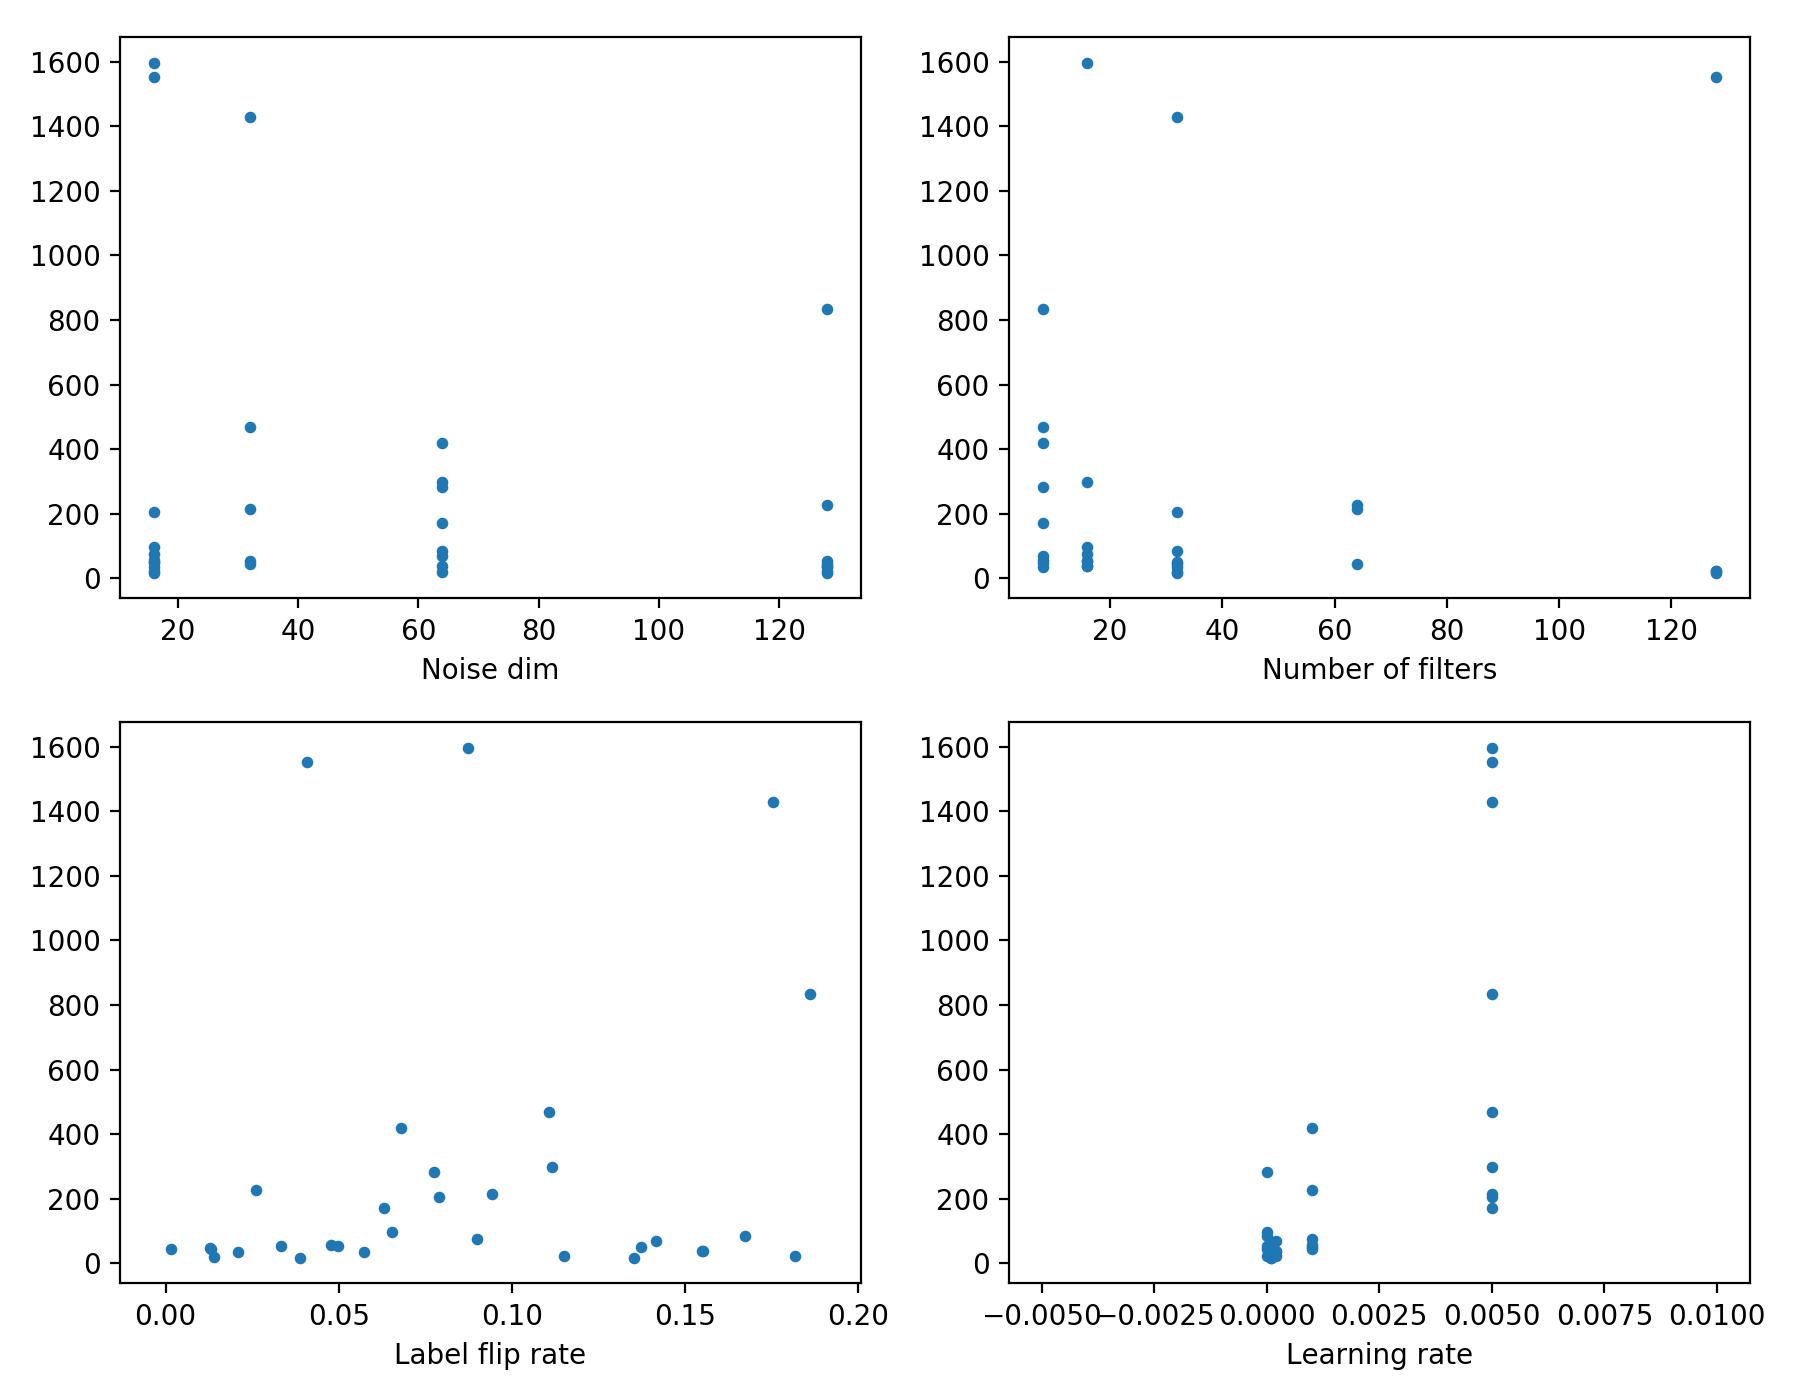

In [14]:
# Metrics vs. noise-dim for best models per HP set
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs[0,0].scatter(hpbest_results.noise_dim, hpbest_results.ks_comb, s=10)
axs[0,0].set_xlabel('Noise dim')
axs[0,1].scatter(hpbest_results.n_filters, hpbest_results.ks_comb, s=10)
axs[0,1].set_xlabel('Number of filters')
axs[1,0].scatter(hpbest_results.flip_rate, hpbest_results.ks_comb, s=10)
axs[1,0].set_xlabel('Label flip rate')
axs[1,1].scatter(hpbest_results.lr, hpbest_results.ks_comb, s=10)
axs[1,1].set_xlabel('Learning rate')
plt.tight_layout()

## Evaluate best model on test set

In [15]:
def load_model(train_dir, checkpoint_id, model_config):
    """Load generator and discriminator from checkpoint"""
    checkpoint_file = os.path.join(
        train_dir, 'checkpoints', 'model_checkpoint_%03i.pth.tar' % checkpoint_id
    )
    # Load the checkpoint and map onto CPU
    checkpoint = torch.load(checkpoint_file, map_location=lambda storage, loc: storage)
    generator = gan.Generator(model_config['noise_dim'],
                              threshold=model_config['threshold'],
                              n_filters=model_config['n_filters'])
    discriminator = gan.Discriminator(n_filters=model_config['n_filters'])
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    # Ensure the model is in eval mode
    return generator.eval(), discriminator.eval()

### Load the test set

In [16]:
input_data = '/global/cscratch1/sd/sfarrell/atlas_gan/data_split/RPV10_1400_850_01_test.npz'

scale = 4e6
n_test = 4096

In [17]:
dataset = RPVImages(input_data, n_samples=n_test, scale=scale)

### Load the best model

In [18]:
best_hp = topk_results.hp.iloc[0]
best_train_dir = train_dirs[best_hp]
best_epoch = topk_results.epoch.iloc[0]
best_config = load_model_config(best_train_dir)
generator, discriminator = load_model(best_train_dir, best_epoch, best_config)

### Evaluate the test set

In [19]:
# Real images and reconstructed physics variables
test_real = Variable(dataset.data, volatile=True)
real_images = inverse_transform_data(dataset.data.numpy().squeeze(1), scale)
real_vars = compute_physics_variables(real_images)

In [20]:
# Generated images and reconstructed physics variables
test_noise = Variable(generate_noise(n_test, best_config['noise_dim']), volatile=True)
test_fake = generator(test_noise)
fake_images = inverse_transform_data(test_fake.data.numpy().squeeze(1), scale)
fake_vars = compute_physics_variables(fake_images)

In [21]:
def plot_physics(real_pixels, fake_pixels,
                 real_vars, fake_vars,
                 figsize=(9, 6), linewidth=1):
    
    fig1, axs = plt.subplots(2, 3, figsize=(9, 6))
    (ax0, ax1, ax2), (ax3, ax4, ax5) = axs
    
    # Pixel energy
    hist_args = dict(bins=100, range=(0, 1e3), log=True, histtype='step', linewidth=linewidth)
    ax0.hist(real_pixels.flatten()*1e-3, label='real', **hist_args)
    ax0.hist(fake_pixels.flatten()*1e-3, label='fake', **hist_args)
    ax0.set_xlabel('Pixel energy [GeV]')
    ax0.legend(loc=0)
    
    # Jet multiplicity
    hist_args = dict(bins=10, range=(0, 10), log=False, histtype='step', linewidth=linewidth)
    ax1.hist(real_vars['nJet'], label='real', **hist_args)
    ax1.hist(fake_vars['nJet'], label='fake', **hist_args)
    ax1.set_xlabel('Number of jets')
    ax1.legend(loc=0)

    # Sum of jet mass
    hist_args = dict(bins=20, range=(0, 2e3), log=False, histtype='step', linewidth=linewidth)
    ax2.hist(real_vars['sumMass']*1e-3, label='real', **hist_args)
    ax2.hist(fake_vars['sumMass']*1e-3, label='fake', **hist_args)
    ax2.set_xlabel('Sum of jet mass [GeV]')
    ax2.legend(loc=0)
    
    # Jet PT
    hist_args = dict(bins=20, range=(0, 2e3), histtype='step', linewidth=linewidth, log=False)
    ax3.hist(real_vars['jetPt']*1e-3, label='real', **hist_args)
    ax3.hist(fake_vars['jetPt']*1e-3, label='fake', **hist_args)
    ax3.set_xlabel('Jet $p_T$ [GeV]')
    ax3.legend(loc=0)

    # Jet eta
    hist_args = dict(bins=20, range=(-2, 2), histtype='step', linewidth=linewidth)
    ax4.hist(real_vars['jetEta'], label='real', **hist_args)
    ax4.hist(fake_vars['jetEta'], label='fake', **hist_args)
    ax4.set_xlabel('Jet $\eta$')
    ax4.legend(loc=0)

    # Jet phi
    hist_args = dict(bins=20, range=(-np.pi, np.pi), histtype='step', linewidth=linewidth)
    ax5.hist(real_vars['jetPhi'], label='real', **hist_args)
    ax5.hist(fake_vars['jetPhi'], label='fake', **hist_args)
    ax5.set_xlabel('Jet $\phi$')
    ax5.legend(loc=0)

    plt.tight_layout()

<IPython.core.display.Javascript object>


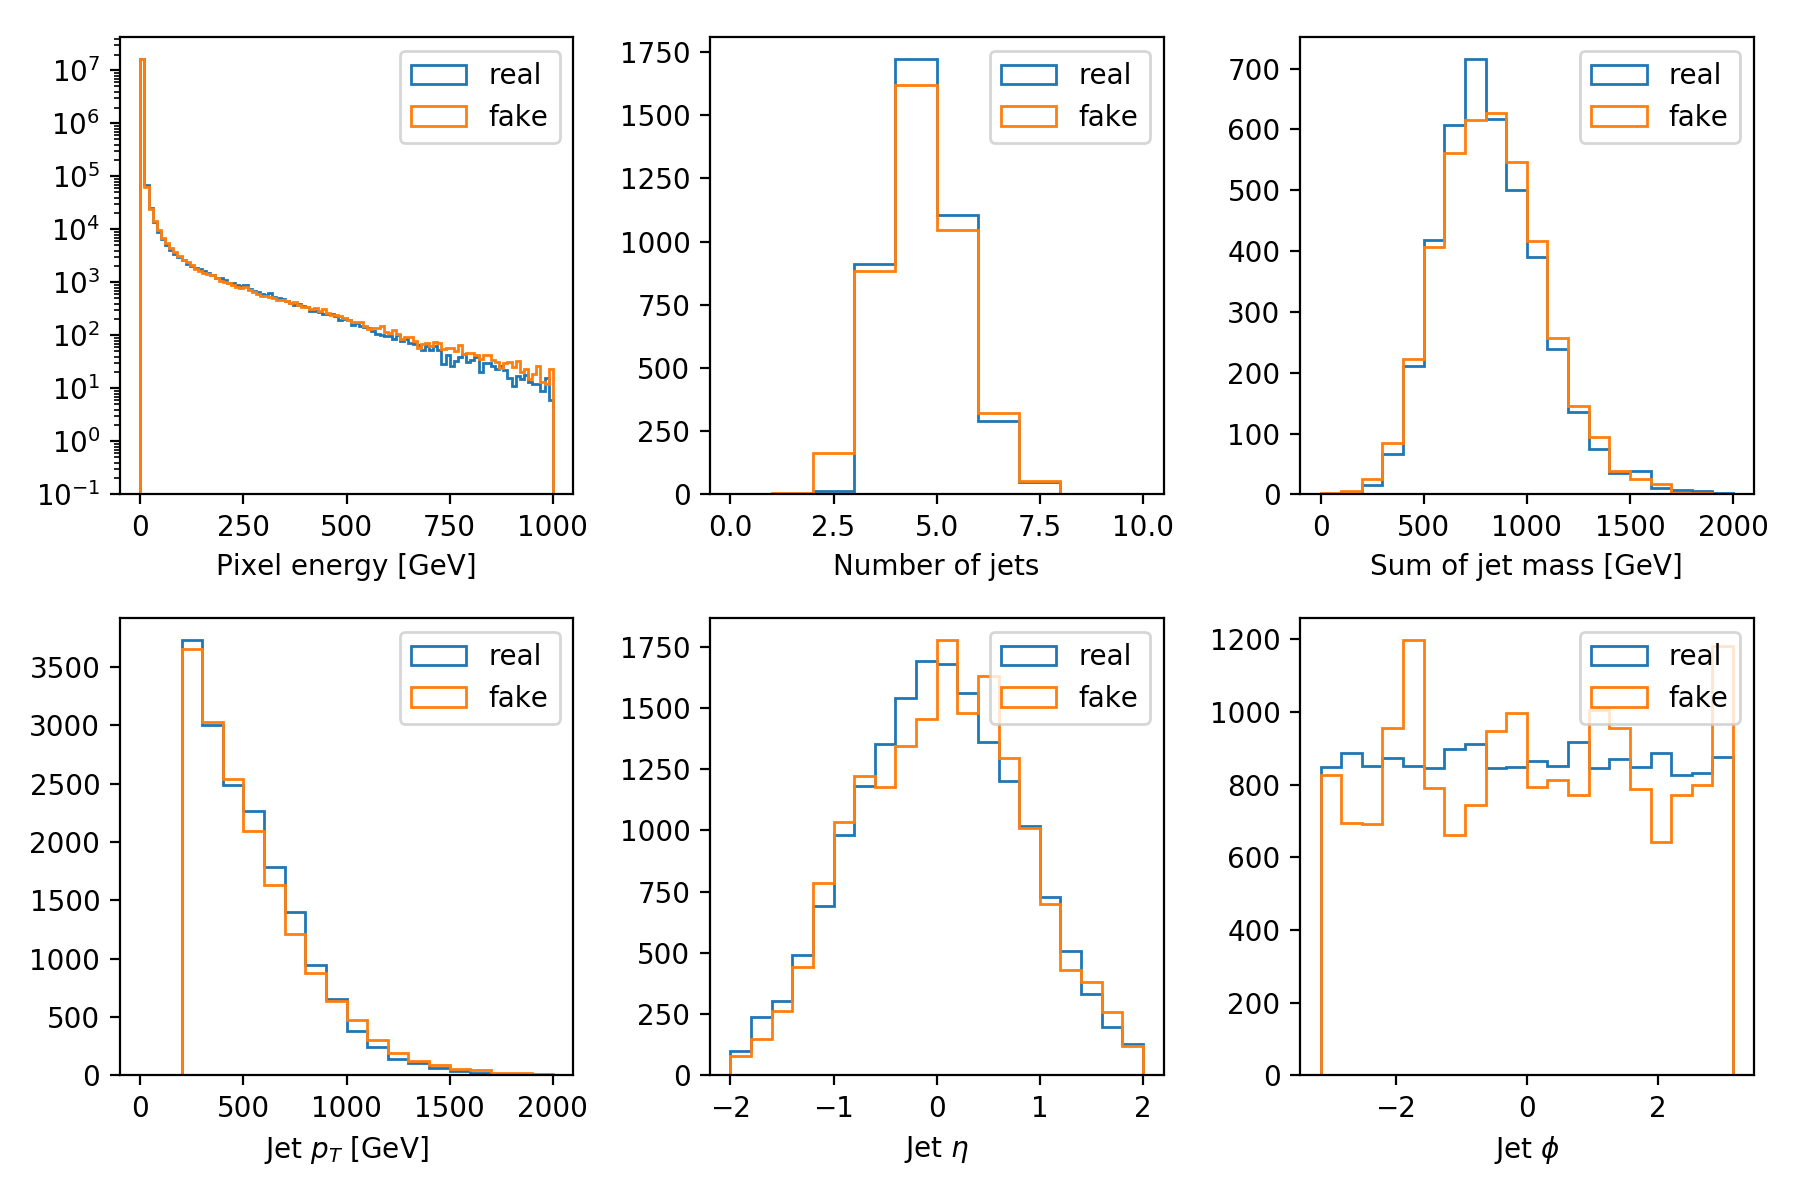

In [22]:
plot_physics(real_images, fake_images, real_vars, fake_vars)

## Average images

<IPython.core.display.Javascript object>


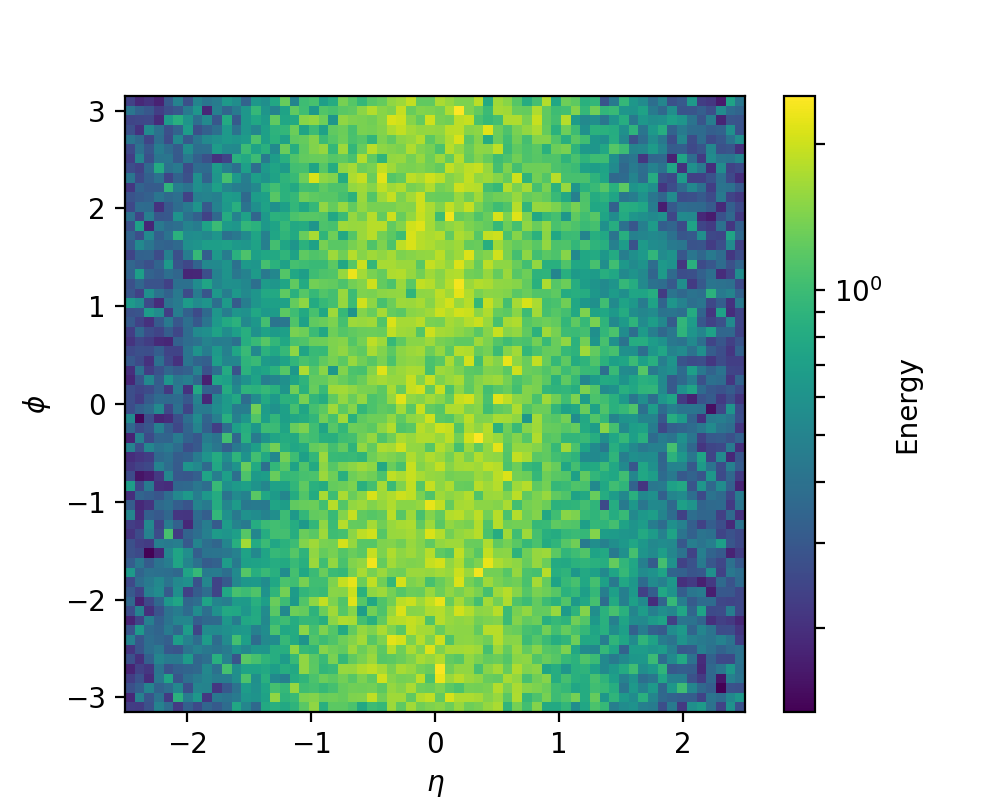

In [23]:
# Plot the average real image
draw_image(real_images.sum(axis=0)*1e-3 / n_test)

<IPython.core.display.Javascript object>


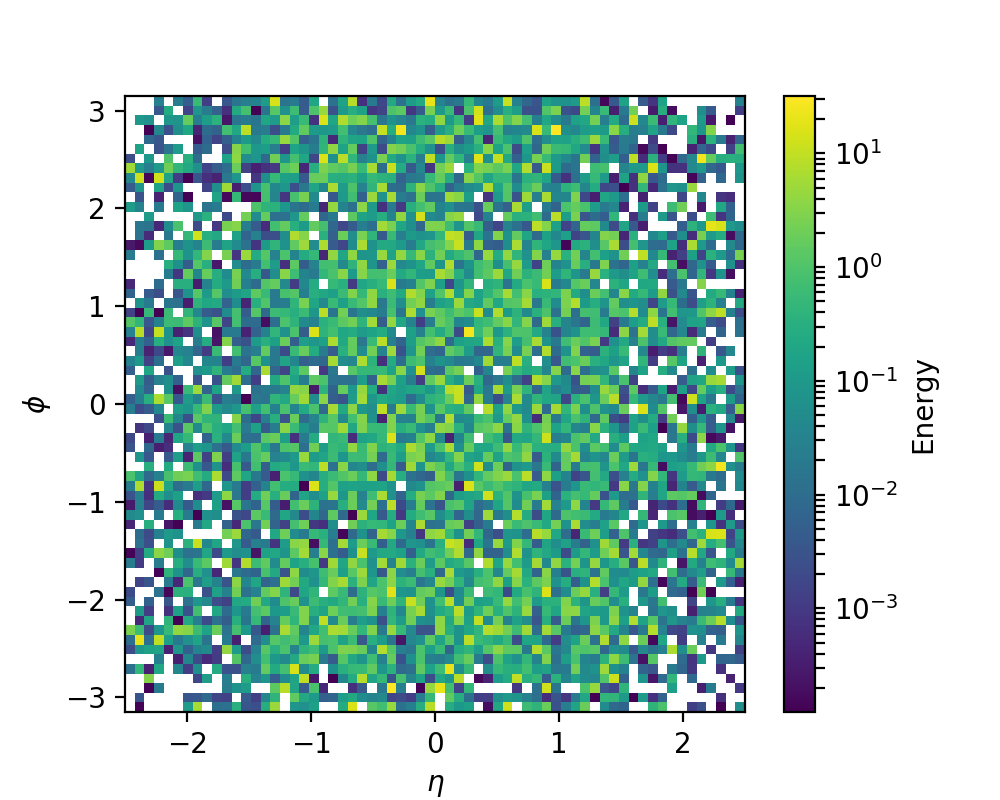

In [24]:
# Plot the average real image
draw_image(fake_images.sum(axis=0)*1e-3 / n_test)

## View sample images

## Discussion